In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
np.random.seed(42)

C:\ProgramData\Anaconda3\envs\torchvision2\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df['UID'] = df['UID'] - 1
df['JID'] = df['JID'] - 1
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

df

df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

In [4]:
with open('predictions_df.pkl', 'rb') as f:
    predictions_df = pickle.load(f)
    
predictions_df.keys()

dict_keys(['actual', 'svd'])

In [5]:
with open('predictions_df_lfm.pkl', 'rb') as f:
    predictions_df_lfm = pickle.load(f)
    
predictions_df_lfm.keys()

dict_keys(['lfm', 'lfm_cos'])

In [6]:
with open('predictions_df_nn.pkl', 'rb') as f:
    predictions_df_nn = pickle.load(f)
    
predictions_df_nn.keys()

dict_keys(['nn'])

In [ ]:
with open('predictions_df_catboost.pkl', 'rb') as f:
    predictions_df_catboost = pickle.load(f)
    
predictions_df_catboost.keys()

In [7]:
svd_df = predictions_df['svd']
lfm_df = predictions_df_lfm['lfm']
lfm_cos_df = predictions_df_lfm['lfm_cos']
nn_df = predictions_df_nn['nn']
catboost_df = predictions_df_catboost['catboost']
actual_df = predictions_df['actual']

In [9]:
frames = {'svd':svd_df, 'lfm':lfm_df, 'lfm_cos':lfm_cos_df, 'nn':nn_df, 'catboost':catboost_df}

In [12]:
predictions = {k:list(v.groupby('UID').agg({'JID':list})['JID'].values) for k, v in frames.items()}

In [13]:
actual = list(predictions_df['actual'].groupby('UID').agg({'JID':list})['JID'].values)

In [14]:

def _precision(predicted, actual):
    prec = [value for value in predicted if value in actual]
    prec = float(len(prec)) / float(len(predicted))
    return prec

def _apk(actual: list, predicted: list, k=10) -> float:
    """
    average precision @ k.
    
    """
    #if not predicted or not actual:
    #    return 0.0
    
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    true_positives = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            max_ix = min(i + 1, len(predicted))
            score += _precision(predicted[:max_ix], actual)
            true_positives += 1
    
    if score == 0.0:
        return 0.0
    
    return score / true_positives


def mapk(actual: List[list], predicted: List[list], k: int=10) -> float:
    """
    mean average precision @ k.
    
    """
    if len(actual) != len(predicted):
        print(len(actual), len(predicted))
        raise AssertionError("Length mismatched")
    
    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])


def mapk_plot(mapk_scores, model_names, k_range):
    """
    Plots the mean average precision at k for a set of models to compare.
    ----------
    mapk_scores: list of lists
        list of list of map@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A map@k plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')
    plt.show()

  0%|          | 0/19 [00:00<?, ?it/s]

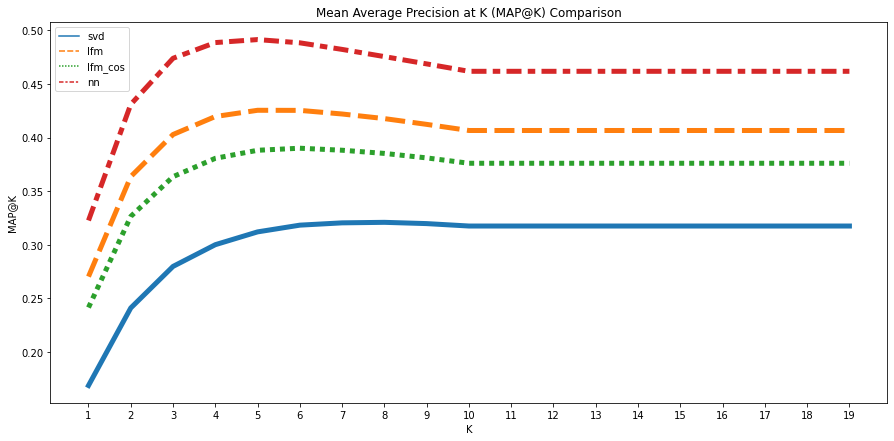

In [18]:


mapk_scores = [[] for _ in predictions]
names = list(predictions.keys())
for K in tqdm(np.arange(1, 20)):
    for i, (key, value) in enumerate(predictions.items()):
        mapk_scores[i].extend([mapk(actual, value, k=K)])
    

    
    
index = range(1,19+1)

fig = plt.figure(figsize=(15, 7))
mapk_plot(mapk_scores, model_names=names, k_range=index)

In [19]:
def get_value_popularity_ranks(values: pd.Series) -> pd.Series:
    value_counts = values.value_counts()
    counts_unique = value_counts.unique()
    count_rank_mapping = pd.Series(index=counts_unique, data=np.arange(len(counts_unique)) + 1)
    return value_counts.map(count_rank_mapping)


def calculate_serendipity_per_user(
    recommendations: pd.DataFrame,
    train: pd.DataFrame,
    test: pd.DataFrame,
) -> pd.Series:
    recommendations_ = pd.merge(recommendations, test[["UID", "JID"]], how="left", indicator=True)
    recommendations_["is_rel"] = np.where(recommendations_["_merge"] == "both", 1, 0)

    n_items = train["JID"].nunique()
    item_popularity_ranks = get_value_popularity_ranks(train["JID"])
    recommendations_["rank_pop"] = recommendations_["JID"].map(item_popularity_ranks)

    recommendations_["proba_user"] = (n_items + 1 - recommendations_["Ratings_pred"]) / n_items
    recommendations_["proba_any_user"] = (n_items + 1 - recommendations_["rank_pop"]) / n_items

    recommendations_["proba_diff"] = np.maximum(
        recommendations_["proba_user"] - recommendations_["proba_any_user"],
        0.0
    )
    recommendations_["item_serendipity"] = recommendations_["proba_diff"] * recommendations_["is_rel"]
    return recommendations_[["UID", "item_serendipity"]].groupby("UID").agg("mean")


In [21]:
for key, value in frames.items():
    display(value)

,UID,JID,Ratings_pred,Rating,_merge
0,0,89,2.567916,NaN,left_only
1,0,36,2.434737,NaN,left_only
2,0,27,2.247942,NaN,left_only
3,0,62,2.217535,NaN,left_only
4,0,72,1.937119,NaN,left_only
...,...,...,...,...,...
249825,24982,55,3.378880,NaN,left_only
249826,24982,80,3.014512,NaN,left_only
249827,24982,89,2.415322,NaN,left_only
249828,24982,1,2.125170,NaN,left_only


,UID,JID,rank
0,19207,87,1
0,19207,98,2
0,19207,86,3
0,19207,82,4
0,19207,83,5
...,...,...,...
24982,10935,64,6
24982,10935,65,7
24982,10935,19,8
24982,10935,60,9


,UID,JID,rank
0,19207,87,1
0,19207,86,2
0,19207,79,3
0,19207,83,4
0,19207,74,5
...,...,...,...
24982,10935,65,6
24982,10935,49,7
24982,10935,19,8
24982,10935,60,9


,UID,JID,Rating_pred,Rating,_merge
0,0,65,-0.137121,NaN,left_only
1,0,88,-0.259286,NaN,left_only
2,0,75,-0.612579,NaN,left_only
3,0,71,-0.736927,NaN,left_only
4,0,26,-0.947321,NaN,left_only
...,...,...,...,...,...
249825,24982,20,3.726145,NaN,left_only
249826,24982,48,3.650551,NaN,left_only
249827,24982,87,3.635036,NaN,left_only
249828,24982,67,3.621434,NaN,left_only


In [43]:
for key, value in frames.items():
    c = value.columns
    if '_merge' in c:        
        #print(value.drop(columns = ['Rating','_merge']).columns)
        print(key, calculate_serendipity_per_user(value.drop(columns = ['Rating','_merge']).rename(columns = {'Rating_pred':'Ratings_pred'}), df_train, df_test).mean())
    elif 'rank' in c:    
        #print(value.rename(columns = {'rank':'Ratings_pred'}).columns)
        print(
            key, calculate_serendipity_per_user(
                value.rename(columns = {'rank':'Ratings_pred'}), df_train, df_test).mean())
        
    elif 'Rating_pred' in c:
        #print(c)
        print(key, calculate_serendipity_per_user(
                value.rename(columns = {'Rating_pred':'Ratings_pred'}), df_train, df_test).mean())
        #print(key, calculate_serendipity_per_user(value, df_train, df_test).mean())
    #break
    #

svd item_serendipity    0.151552
dtype: float64
lfm item_serendipity    0.168735
dtype: float64
lfm_cos item_serendipity    0.250702
dtype: float64
nn item_serendipity    0.091932
dtype: float64


In [45]:
def novelty(predicted: List[list], pop: dict, u: int, n: int) -> (float, list):
    """
    Новизна рекомендаций 
    ----------    
    Базируется на статье:
    Zhou, T., Kuscsik, Z., Liu, J. G., Medo, M., Wakeling, J. R., & Zhang, Y. C. (2010).
    Solving the apparent diversity-accuracy dilemma of recommender systems.
    Proceedings of the National Academy of Sciences, 107(10), 4511-4515.
    """
    mean_self_information = []
    k = 0
    for sublist in predicted:
        self_information = 0
        k += 1
        for i in sublist:
            self_information += np.sum(-np.log2(pop[i]/u))
        mean_self_information.append(self_information/n)
    novelty = sum(mean_self_information)/k
    return novelty, mean_self_information


In [46]:
nov = df.JID.value_counts()
pop = dict(nov)
users = np.unique(df['UID'])

nov_dict = {}
for i, (key, value) in enumerate(predictions.items()):
    nov, _ = novelty(value, pop, len(users), 10)
    nov_dict[key] = nov
    
nov_dict

{'svd': 0.8155996312339772,
 'lfm': 0.5569537579748091,
 'lfm_cos': 0.8783698040593366,
 'nn': 0.6580521718327331}

In [22]:
users = np.unique(df['UID'])
users

array([    0,     1,     2, ..., 24980, 24981, 24982], dtype=int64)

In [23]:
nov = df.JID.value_counts()
pop = dict(nov)


svd_novelty, svd_mselfinfo_list = novelty(svd_predictions, pop, len(users), 10)
lfm_novelty, lfm_mselfinfo_list = novelty(lfm_predictions, pop, len(users), 10)
lfm_cos_novelty, lfm_cos_mselfinfo_list = novelty(lfm_cos_predictions, pop, len(users), 10)
svd_novelty, lfm_novelty, lfm_cos_novelty

(0.8155996312339772, 0.5569537579748091, 0.8783698040593366)

In [ ]:
assert False

In [51]:
items = np.unique(df['JID'])
items

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [52]:
def prediction_coverage(predicted: List[list], catalog: list, unseen_warning: bool=False) -> float:
    """
    Покрытие рекомендаций (по пользователю)
    
    ----------    
    Базируется на статье:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    
    unique_items_catalog = set(catalog)
    if len(catalog)!=len(unique_items_catalog):
        raise AssertionError("Дубликаты в каталоге")

    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_items_pred = set(predicted_flattened)
    
    if not unique_items_pred.issubset(unique_items_catalog):
        if unseen_warning:
            warnings.warn("В рекомендациях есть элементы не из каталога. "
                "Игнорируем")
            unique_items_pred = unique_items_pred.intersection(unique_items_catalog)
        else:
            print(unique_items_pred - unique_items_catalog)
            raise AssertionError("В рекомендациях есть элементы не из каталога.")
    
    num_unique_predictions = len(unique_items_pred)
    prediction_coverage = round(num_unique_predictions/(len(catalog)* 1.0)* 100, 2)
    return prediction_coverage



In [53]:

cov_dict = {}
for i, (key, value) in enumerate(predictions.items()):
    cov = prediction_coverage(value, items)
    cov_dict[key] = cov

    
cov_dict

{'svd': 100.0, 'lfm': 100.0, 'lfm_cos': 100.0, 'nn': 95.0}

In [27]:


#random_coverage = prediction_coverage(ran_recs, items)
#pop_coverage = prediction_coverage(pop_recs, items)
cf_coverage = prediction_coverage(svd_predictions, items)
lfm_coverage = prediction_coverage(lfm_predictions, items)
lfm_cos_coverage = prediction_coverage(lfm_cos_predictions, items)


#random_coverage, pop_coverage, 
cf_coverage, lfm_coverage, lfm_cos_coverage

(100.0, 100.0, 100.0)

In [54]:

def catalog_coverage(predicted: List[list], catalog: list, k: int) -> float:
    """
    Покрытие рекомендаций (по каталогу)
    
    ----------
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage



def coverage_plot(coverage_scores: list, model_names: list) -> None:
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

In [55]:

catalog_cov_dict = {}
for i, (key, value) in enumerate(predictions.items()):
    cov = catalog_coverage(value, items, 100)
    catalog_cov_dict[key] = cov

    
catalog_cov_dict

{'svd': 97.0, 'lfm': 98.0, 'lfm_cos': 100.0, 'nn': 49.0}

In [31]:
# N=100 для определенного 
#random_cat_coverage = catalog_coverage(ran_recs, items, 100)
#pop_cat_coverage = catalog_coverage(pop_recs, items, 100)
cf_cat_coverage = catalog_coverage(svd_predictions, items, 100)
lfm_cat_coverage = catalog_coverage(lfm_predictions, items, 100)
lfm_cos_cat_coverage = catalog_coverage(lfm_cos_predictions, items, 100)

In [32]:

cf_cat_coverage, lfm_cat_coverage, lfm_cos_cat_coverage

(99.0, 94.0, 100.0)

In [ ]:
predictions_df['actual']

In [ ]:
predictions_df['svd']

In [ ]:
users = np.unique(predictions_df['actual']['UID'])
users

In [ ]:
ndsg = {}

for user in tqdm(users):
    df1 = predictions_df['actual'][predictions_df['actual']['UID'] == user]
    df2 = predictions_df['svd'][predictions_df['svd']['UID'] == user]
    
    break
    
    if len(df_user) < 2:
        continue
    #display(df_user)
    #display(np.asarray([df_user['Ratings']]))
    ndsg[user] = ndcg_score(
        np.asarray([['Ratings']]),
        np.asarray([predictions_df['svd']['Ratings_pred']])
    )

    
np.mean(list(ndsg.values()))

In [ ]:
df1

In [ ]:
df2

In [ ]:
df_pred = df_pred.merge(pd.DataFrame({'UID':ndsg.keys(), 'NDSG': list(ndsg.values())}), how='left')#
df_pred

In [ ]:
df_pred[df_pred['NDSG'].isna()]

In [ ]:
df_pred = df_pred.fillna(0)

In [ ]:
df_pred[df_pred['NDSG'].isna()]

In [ ]:
df_pred['NDSG'].mean()

In [ ]:
pop = dict(df['UID'].value_counts())
pop

In [ ]:
cf_recs = []

for user in tqdm(users):
    df_user = df_pred[df_pred['UID'] == user]
    

In [ ]:
df_pred.index

In [ ]:
test = df_true.copy().groupby('UID', as_index=False)['JID'].agg({'Ratings': (lambda x: list(set(x)))}).sort_values('Ratings')
test = test.set_index("UID")
test

In [ ]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["Ratings_pred"]
    recommended_items = recommended_items.sort_values('Ratings_pred', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [ ]:
cf_model = df_pred.pivot_table(index='UID', columns='JID', values='Ratings_pred').fillna(0)
cf_model

In [ ]:

cf_recs = []
for user in tqdm(test.index):
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

In [ ]:
# рекомендации по популярным 
popularity_recs = df['JID'].value_counts().head(10).index.tolist()

pop_recs = []
for user in tqdm(test.index):
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

In [ ]:
items = np.unique(df['JID'])
items

In [ ]:
# рекомендации случайных
ran_recs = []
for user in tqdm(test.index):
    random_predictions = np.random.choice(items, 10)
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

In [ ]:
actual = test.Ratings.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [ ]:
lfm_dataset = LFMDataset()
lfm_dataset.fit(
    users=df_train["UID"].values,
    items=df_train["JID"].values,
)

train_matrix, _ = lfm_dataset.build_interactions(zip(*df_train[["UID", "JID"]].values.T))

In [ ]:
id_item_mapping = {v: k for k, v in lfm_dataset._item_id_mapping.items()}

In [ ]:
lfm_model = LightFM(
    learning_rate=0.01, 
    loss='warp', 
    no_components=64,
    random_state=42
)
lfm_model.fit(
    interactions=train_matrix, 
    epochs=15,
    num_threads=20
);

In [ ]:
with open('05_jokes_lfm_model.pkl', 'wb') as f:
    pickle.dump(lfm_model, f)

In [ ]:
with open('05_jokes_lfm_dataset.pkl', 'wb') as f:
    pickle.dump(lfm_dataset, f)

In [ ]:
lfm_model_cos = deepcopy(lfm_model)

lfm_model_cos.item_biases = np.zeros_like(lfm_model_cos.item_biases)
lfm_model_cos.user_biases = np.zeros_like(lfm_model_cos.user_biases)

lfm_model_cos.item_embeddings = normalize(lfm_model_cos.item_embeddings)
lfm_model_cos.user_embeddings = normalize(lfm_model_cos.user_embeddings)

In [ ]:
{x:lfm_dataset._user_id_mapping[x] for x in list(lfm_dataset._user_id_mapping.keys())[-10:]}

In [ ]:
recommendations_dict = {}
for model_name, model in tqdm(models_dict.items()):
    recommendations = pd.DataFrame({"UID": df_test["UID"].unique()})
    recommendations["JID"] = recommendations["UID"].apply(
        lfm_get_n_recommendations_for_user,
        args=(
            model,
            train_matrix,
            lfm_dataset._user_id_mapping,
            id_item_mapping,
            n_predict,
            model_name
        ),
    )
    recommendations = recommendations.explode("JID")
    recommendations["rank"] = recommendations.groupby(["UID"]).cumcount() + 1
    recommendations_dict[model_name] = recommendations
    

In [ ]:
test

In [ ]:
actual = test.Ratings.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [ ]:
actual = df_test.groupby('UID', as_index=False)['JID'].agg({'JID': (lambda x: list(set(x)))}).sort_values('UID').JID.values.tolist()
actual

In [ ]:
lfm = recommendations_dict['lfm'].groupby('UID', as_index=False)['JID'].agg({'JID': (lambda x: list(set(x)))}).sort_values('UID').JID.values.tolist()
lfm

In [ ]:
lfm_cos = recommendations_dict['lfm_cos'].groupby('UID', as_index=False)['JID'].agg({'JID': (lambda x: list(set(x)))}).sort_values('UID').JID.values.tolist()
lfm_cos

In [ ]:

pop_mapk = []
for K in np.arange(1, 20):
    pop_mapk.extend([mapk(actual, pop_predictions, k=K)])


random_mapk = []
for K in np.arange(1, 20):
    random_mapk.extend([mapk(actual, random_predictions, k=K)])


cf_mapk = []
for K in np.arange(1, 20):
    cf_mapk.extend([mapk(actual, cf_predictions, k=K)])

In [ ]:

lfm_mapk = []
for K in np.arange(1, 20):
    lfm_mapk.extend([mapk(actual, lfm, k=K)])
    

lfm_cos_mapk = []
for K in np.arange(1, 20):
    lfm_cos_mapk.extend([mapk(actual, lfm_cos, k=K)])

In [ ]:

mapk_scores = [random_mapk, pop_mapk, cf_mapk, lfm_mapk, lfm_cos_mapk]
index = range(1,19+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter', 'LightFM', 'LightFM_cos']

fig = plt.figure(figsize=(15, 7))
mapk_plot(mapk_scores, model_names=names, k_range=index)

In [ ]:
cf_recs

In [ ]:

def catalog_coverage(predicted: List[list], catalog: list, k: int) -> float:
    """
    Покрытие рекомендаций (по каталогу)
    
    ----------
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage



def coverage_plot(coverage_scores: list, model_names: list) -> None:
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

In [ ]:
# N=100 для определенного 
random_cat_coverage = catalog_coverage(ran_recs, items, 100)
pop_cat_coverage = catalog_coverage(pop_recs, items, 100)
cf_cat_coverage = catalog_coverage(cf_recs, items, 100)
lfm_cat_coverage = catalog_coverage(lfm, items, 100)
lfm_cat_cos_coverage = catalog_coverage(lfm_cos, items, 100)

In [ ]:
# визуализация
coverage_scores = [random_coverage, pop_coverage, cf_coverage, lfm_cat_coverage, lfm_cat_cos_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter', 'lfm', 'lfm_cos']

fig = plt.figure(figsize=(7, 5))
coverage_plot(coverage_scores, model_names)

In [ ]:
nov = df.JID.value_counts()
pop = dict(nov)

In [ ]:
random_novelty,random_mselfinfo_list = novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = novelty(cf_recs, pop, len(users), 10)
lfm_novelty,lfm_mselfinfo_list = novelty(lfm, pop, len(users), 10)
lfm_cos_novelty,lfm_cos_mselfinfo_list = novelty(lfm_cos, pop, len(users), 10)

In [ ]:
print(random_novelty, pop_novelty, cf_novelty, lfm_novelty, lfm_cos_novelty)

In [ ]:
test_set_all

In [ ]:
predictions_all

In [ ]:
get_n_recommendations_for_user(df_pred_all, 4, 10)

In [ ]:
df_rec

In [ ]:
calculate_serendipity_per_user(df_rec, df_train, df_test).mean()

In [ ]:
calculate_serendipity_per_user(df_pred, df_train, df_test).mean()